In [22]:
# Importing Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import pandas as pd
from datasets import load_dataset

# Loading Data
df = load_dataset('lukebarousse/data_jobs', split='train').to_pandas()

# Save the raw data
df.to_csv('C:/Users/DELL/Job-Postings-Analysis/data/raw_data.csv', index=False)

import ast
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)



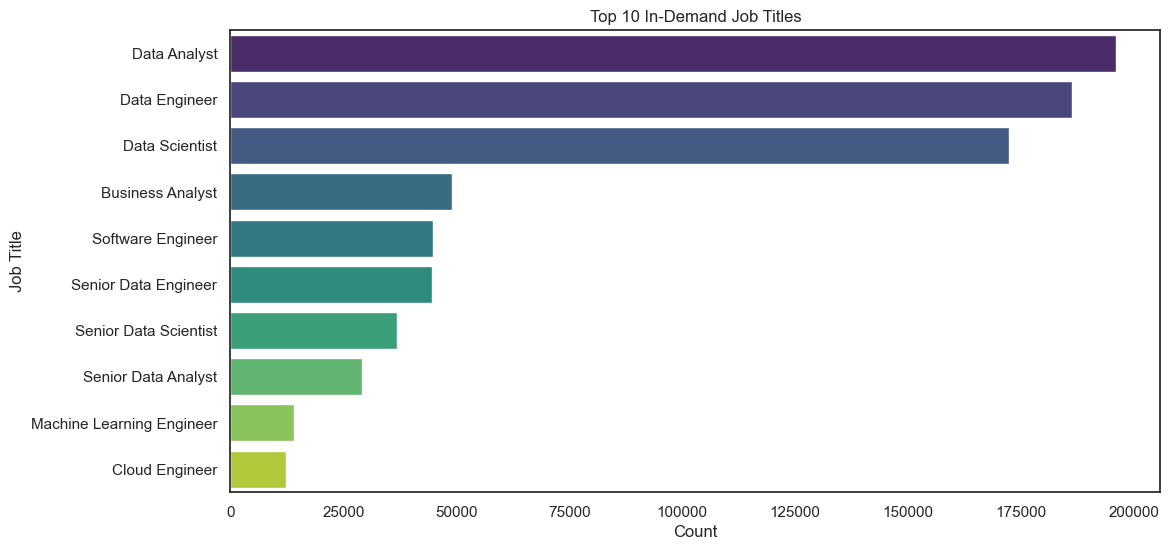

In [23]:
# Job Titles Distribution
plt.figure(figsize=(12, 6))
sns.countplot(
    y=df['job_title_short'], 
    order=df['job_title_short'].value_counts().index[:10], 
    palette='viridis'
)
plt.title('Top 10 In-Demand Job Titles')
plt.xlabel('Count')
plt.ylabel('Job Title')
plt.show()


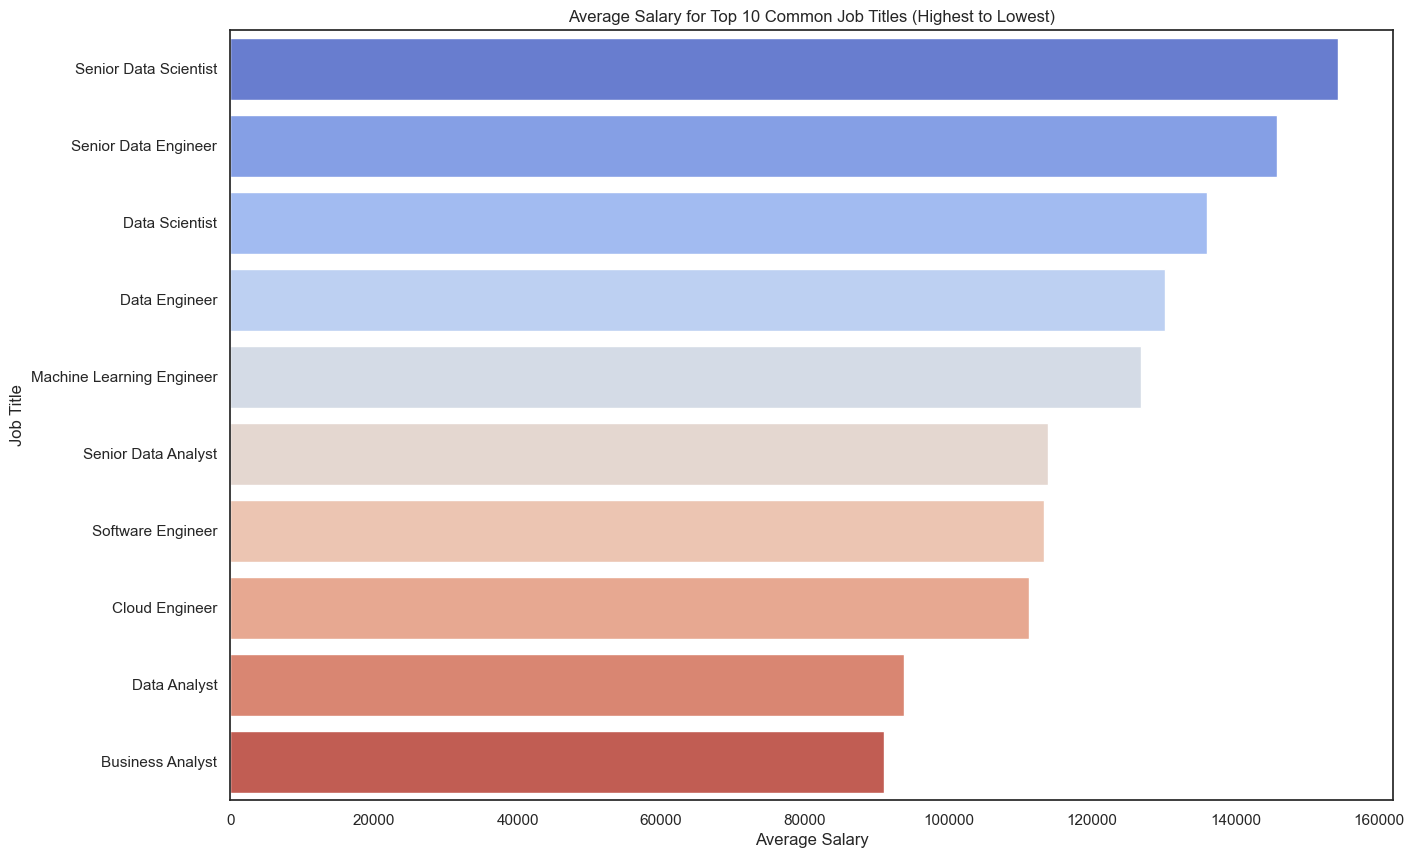

In [24]:
# Salary Distribution of the Top Requested Jobs
top_jobs = df['job_title_short'].value_counts().index[:10]
top_jobs_df = df[df['job_title_short'].isin(top_jobs)]
mean_salaries = top_jobs_df.groupby('job_title_short')['salary_year_avg'].mean().sort_values(ascending=False)

sns.set_theme(style='white')
plt.figure(figsize=(15, 10))
sns.barplot(x=mean_salaries.values, y=mean_salaries.index, order=mean_salaries.index, palette='coolwarm')
plt.title('Average Salary for Top 10 Common Job Titles (Highest to Lowest)')
plt.xlabel('Average Salary')
plt.ylabel('Job Title')
plt.show()

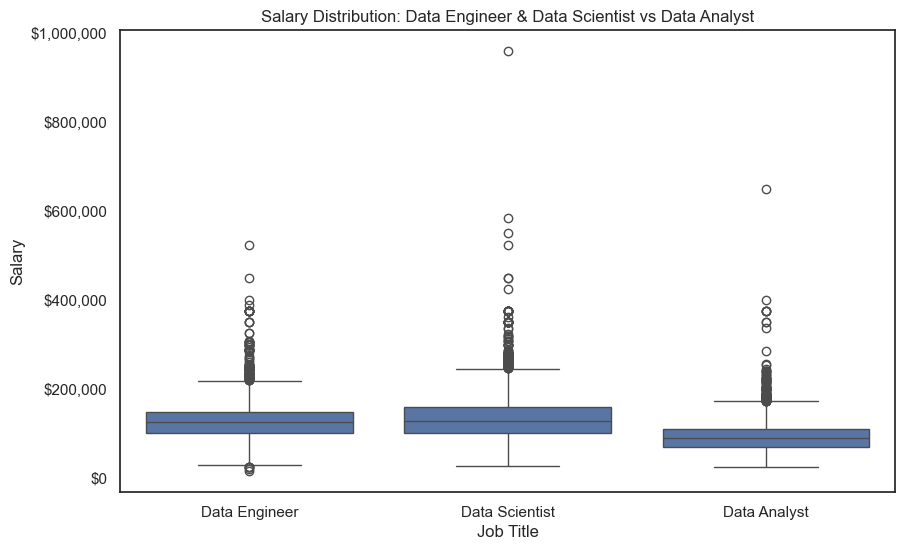

In [25]:
# Salary Distribution: Data Engineer vs Data Scientist
df_DE_DS_DA = df[df['job_title_short'].isin(['Data Engineer', 'Data Scientist', 'Data Analyst'])].copy()
plot_order = ['Data Engineer', 'Data Scientist', 'Data Analyst']

sns.set_theme(style='white')
plt.figure(figsize=(10, 6))
sns.boxplot(x='job_title_short', y='salary_year_avg', data=df_DE_DS_DA, order=plot_order)
plt.title('Salary Distribution: Data Engineer & Data Scientist vs Data Analyst')
plt.xlabel('Job Title')
plt.ylabel('Salary')

# Format y-axis ticks to show currency
import matplotlib.ticker as ticker
def currency_formatter(x, p):
    return f'${x:,.0f}' # No decimals, with comma separators and dollar sign

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

plt.show()


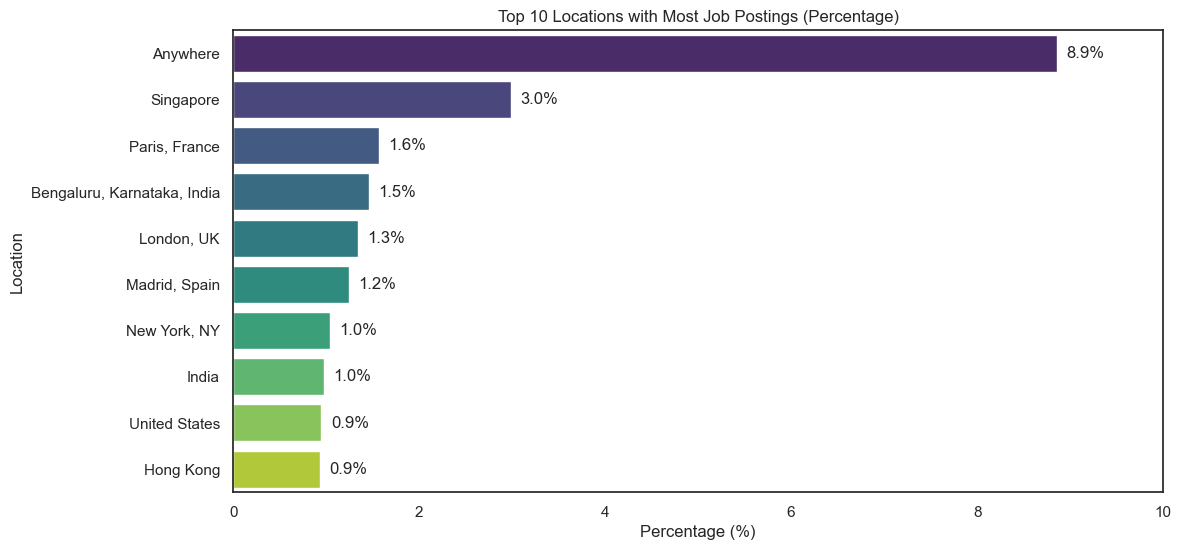

In [26]:

# Calculate the percentage of job postings by location
location_percentages = (df['job_location'].value_counts(normalize=True) * 100).head(10)
sns.set_theme(style='white')

# Plot the percentage distribution with annotations
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    y=location_percentages.index, 
    x=location_percentages.values, 
    palette='viridis'
)

plt.title('Top 10 Locations with Most Job Postings (Percentage)')
plt.xlabel('Percentage (%)')
plt.ylabel('Location')
plt.xlim(0,10)


# Add percentage annotations to each bar
for i, v in enumerate(location_percentages.values):
    ax.text(v + 0.1, i, f'{v:.1f}%', va='center')

plt.show()


In [27]:

df_skills = df_DE_DS_DA.explode('job_skills')
skills_count = df_skills.groupby(['job_skills',"job_title_short"]).size()
df_skills_count = skills_count.reset_index(name = 'skill_count')
df_skills_count.sort_values(by = 'skill_count', ascending= False, inplace = True )

df_skills_count


,job_skills,job_title_short,skill_count
471,python,Data Scientist,113711
575,sql,Data Engineer,113130
470,python,Data Engineer,108022
574,sql,Data Analyst,92428
576,sql,Data Scientist,78982
...,...,...,...
306,linode,Data Engineer,1
334,mattermost,Data Scientist,1
359,msaccess,Data Analyst,1
399,nuxt.js,Data Analyst,1


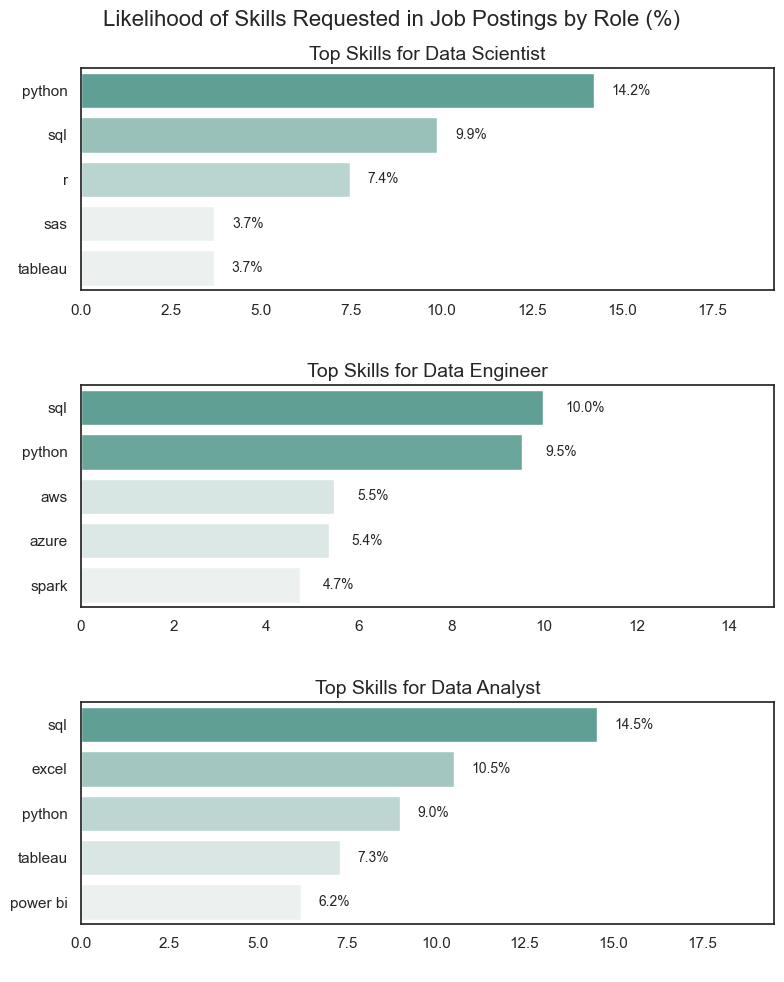

In [28]:

sns.set_theme(style='white')

# Calculate percentage of skill requirement within each job role
df_skills_count['skill_percent'] = (
    df_skills_count['skill_count'] / df_skills_count.groupby('job_title_short')['skill_count'].transform('sum') * 100
)

# Prepare the plot
job_titles = df_skills_count['job_title_short'].unique()
fig, ax = plt.subplots(len(job_titles), 1, figsize=(8, 10))
sns.set_theme(style='ticks')

# Iterate over job titles to create individual subplots
for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)
    
    sns.barplot(
        data=df_plot,
        x='skill_percent',
        y='job_skills',
        ax=ax[i],
        hue= 'skill_count',
        palette='light:#5A9'
    )
    
    ax[i].set_title(f"Top Skills for {job_title}", fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_xlabel(' ')
    ax[i].legend().set_visible(False)

    # Dynamic x-axis limit for percentages
    max_x = df_plot['skill_percent'].max() + 5
    ax[i].set_xlim(0, max_x)
    
    # Annotate each bar with the percentage
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 0.5, n, f'{v:.1f}%', va='center', fontsize=10)

# Set a super title and adjust layout
fig.suptitle('Likelihood of Skills Requested in Job Postings by Role (%)', fontsize=16)
fig.tight_layout(h_pad=1.5)
plt.show()


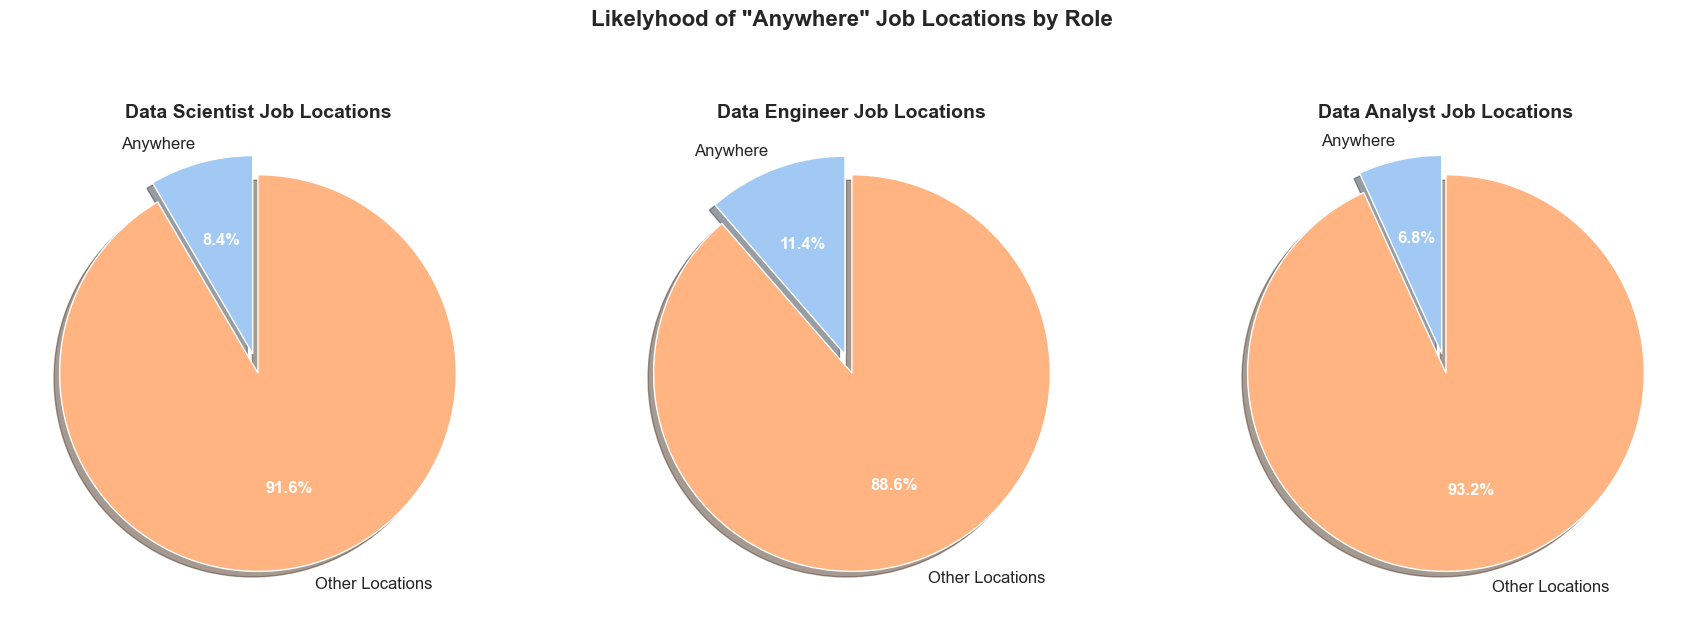

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define roles and colors
roles = ['Data Scientist', 'Data Engineer', 'Data Analyst']
colors = sns.color_palette("pastel")  # Use a soft color palette

# Set up the figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, role in enumerate(roles):
    role_data = df_DE_DS_DA[df_DE_DS_DA['job_title_short'].str.contains(role, case=False, na=False)]
    anywhere_count = role_data[role_data['job_location'] == 'Anywhere'].shape[0]
    total_count = role_data.shape[0]
    
    labels = ['Anywhere', 'Other Locations']
    sizes = [anywhere_count, total_count - anywhere_count]
    
    # Explode the 'Anywhere' slice for emphasis
    explode = [0.1, 0]

    # Plot pie chart
    wedges, texts, autotexts = axes[i].pie(
        sizes, labels=labels, autopct='%1.1f%%', colors=colors[:2],
        startangle=90, explode=explode, shadow=True, textprops={'fontsize': 12}
    )
    
    axes[i].set_title(f'{role} Job Locations', fontsize=14, fontweight="bold")
    
    # Improve label visibility
    for text in autotexts:
        text.set_color('white')
        text.set_fontweight('bold')

# Add a super title with padding for better spacing
plt.suptitle('Likelyhood of "Anywhere" Job Locations by Role', fontsize=16, fontweight="bold", y=1.05)

# Ensure titles are not too close to the chart
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [30]:
# Get unique job locations
unique_countries = df['job_country'].unique()

# Display the unique locations
#print(locations)

# List of African countries for comparison
african_countries = [
    'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
    'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
    'Congo, Democratic Republic of the', 'Congo, Republic of the', 'Côte d\'Ivoire',
    'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia',
    'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho',
    'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius',
    'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe',
    'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan',
    'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'
]

# Extract African countries present in the dataset
african_countries_in_data = [country for country in unique_countries if country in african_countries]
print("African countries in the dataset:", african_countries_in_data)


African countries in the dataset: ['Sudan', 'Namibia', 'Egypt', 'South Africa', 'Nigeria', 'Lesotho', 'Mauritius', "Côte d'Ivoire", 'Tunisia', 'Kenya', 'Senegal', 'Ghana', 'Morocco', 'Guinea', 'Uganda', 'Ethiopia', 'Liberia', 'Burkina Faso', 'Benin', 'Zambia', 'Cameroon', 'Togo', 'Rwanda', 'Algeria', 'Congo, Democratic Republic of the', 'Zimbabwe', 'Mozambique', 'Tanzania', 'Madagascar', 'Mali', 'Malawi', 'Libya', 'Mauritania', 'Botswana', 'Angola', 'Somalia', 'Gambia', 'Djibouti']


In [31]:

# Step 1: Identify the Top 10 Most Commonly Posted Jobs
top_10_jobs = df['job_title'].value_counts().head(10)

# Step 2: Split Data into African and Non-African Locations
african_data = df[df['job_country'].isin(african_countries_in_data)]
non_african_data = df[~df['job_country'].isin(african_countries_in_data)]

# Step 3: Count Job Postings in Each Region
african_job_counts = african_data['job_title'].value_counts()
non_african_job_counts = non_african_data['job_title'].value_counts()

# Step 4: Calculate the Likelihood of Each Top 10 Job in African vs. Non-African Countries
likelihood_comparison = pd.DataFrame({
    'Job Title': top_10_jobs.index,
    'Global Count': top_10_jobs.values,
    'Africa Count': [african_job_counts.get(job, 0) for job in top_10_jobs.index],
    'Non-Africa Count': [non_african_job_counts.get(job, 0) for job in top_10_jobs.index],
})

# Calculate the likelihood percentages
likelihood_comparison['Africa Likelihood (%)'] = (likelihood_comparison['Africa Count'] / likelihood_comparison['Global Count']) * 100
likelihood_comparison['Non-Africa Likelihood (%)'] = (likelihood_comparison['Non-Africa Count'] / likelihood_comparison['Global Count']) * 100

likelihood_comparison

,Job Title,Global Count,Africa Count,Non-Africa Count,Africa Likelihood (%),Non-Africa Likelihood (%)
0,Data Engineer,53908,3372,50536,6.255101,93.744899
1,Data Scientist,42542,3429,39113,8.060270,91.939730
2,Data Analyst,41950,1680,40270,4.004768,95.995232
3,Senior Data Engineer,20217,1389,18828,6.870456,93.129544
4,Senior Data Scientist,13335,1081,12254,8.106487,91.893513
5,Senior Data Analyst,8209,289,7920,3.520526,96.479474
6,Lead Data Engineer,3914,269,3645,6.872764,93.127236
7,Lead Data Scientist,3322,247,3075,7.435280,92.564720
8,Azure Data Engineer,3307,138,3169,4.172966,95.827034
9,Machine Learning Engineer,3097,163,2934,5.263158,94.736842


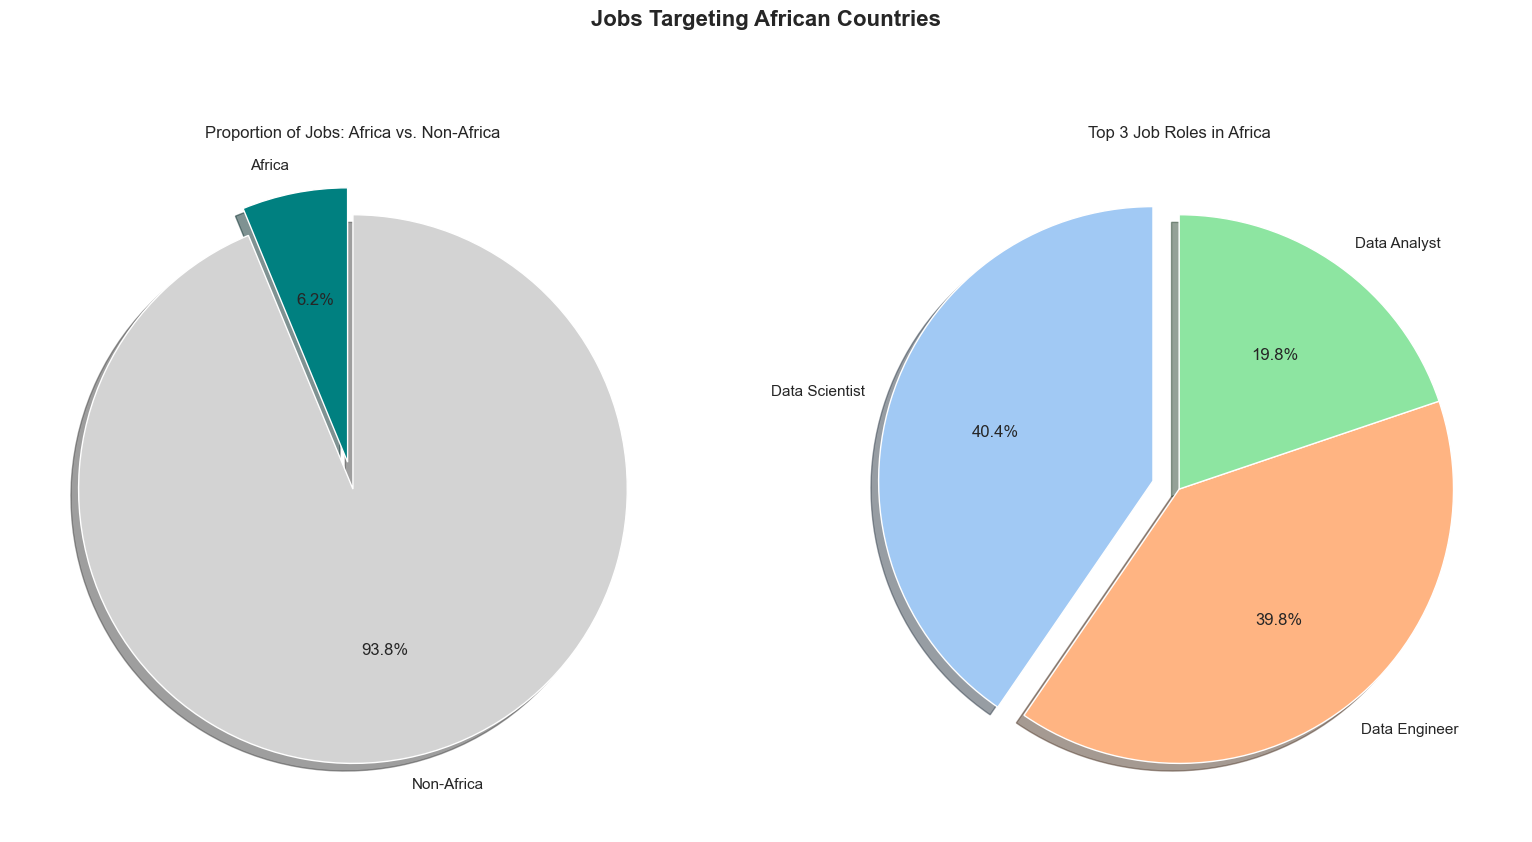

In [32]:

# Set the style for better visuals using seaborn directly
sns.set_theme(style='darkgrid')

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Proportion of Jobs in Africa vs. Non-Africa
total_africa_jobs = likelihood_comparison['Africa Count'].sum()
total_non_africa_jobs = likelihood_comparison['Non-Africa Count'].sum()

axes[0].pie([total_africa_jobs, total_non_africa_jobs], labels=['Africa', 'Non-Africa'], autopct='%1.1f%%', colors=['teal', 'lightgrey'], startangle=90, explode=[0.1, 0], shadow=True)
axes[0].set_title('Proportion of Jobs: Africa vs. Non-Africa')

# Plot 2: Top 3 Most Common Jobs in Africa (Pie Chart)
top_3_african_jobs = likelihood_comparison.nlargest(3, 'Africa Count')

axes[1].pie(top_3_african_jobs['Africa Count'], labels=top_3_african_jobs['Job Title'], autopct='%1.1f%%', colors=sns.color_palette('pastel')[:3], startangle=90, explode=[0.1, 0, 0], shadow=True)
axes[1].set_title('Top 3 Job Roles in Africa')

plt.suptitle('Jobs Targeting African Countries', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [33]:
# Where are African Jobs Comming from ?
african_jobs = df[df['job_country'].isin(african_countries_in_data)]

# Getting the top companies with the most job postings in Africa
top_african_companies = african_jobs['company_name'].value_counts().head(10)

print("Top Companies Posting Jobs in Africa:\n", top_african_companies)


Top Companies Posting Jobs in Africa:
 company_name
E-Merge                536
Upwork                 435
Walmart                390
Dice                   331
findojobs-za           322
Capital One            265
Confidential           214
Booz Allen Hamilton    210
Network Recruitment    205
SynergisticIT          205
Name: count, dtype: int64


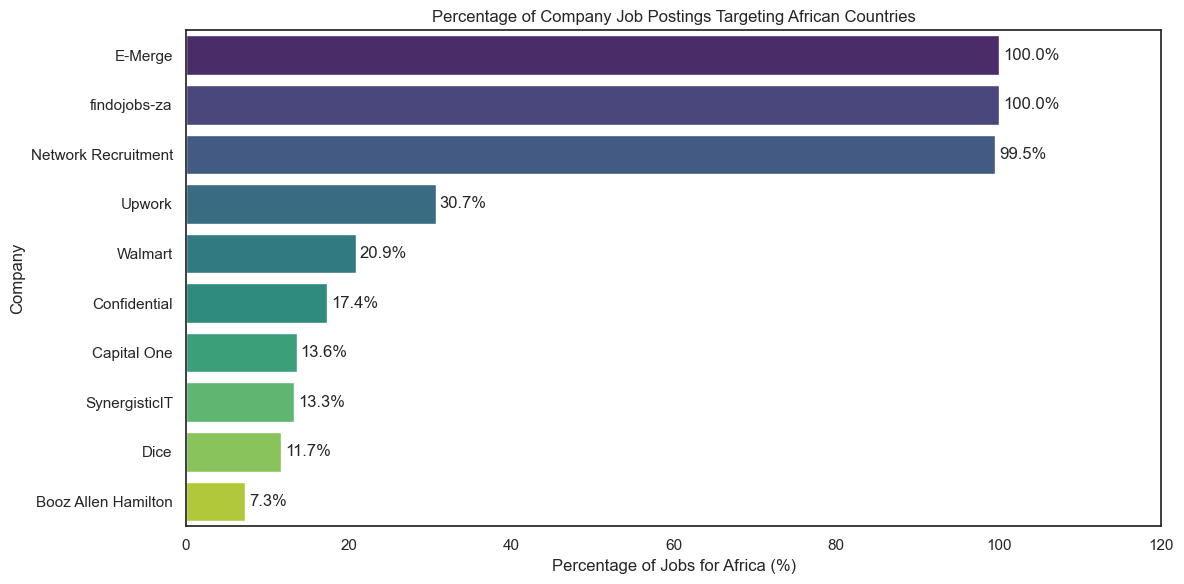

In [34]:

# Ensure consistent styling
sns.set_theme(style='white')

# Calculate total global job postings for the top African companies
global_company_counts = df['company_name'].value_counts().loc[top_african_companies.index]

# Calculate the percentage of African job postings
african_job_counts = top_african_companies
african_job_percentages = (african_job_counts / global_company_counts * 100).round(1)

# Sort by African job counts (descending)
african_job_percentages = african_job_percentages.sort_values(ascending=False)

# Visualization: Bar Chart with Percentage Annotations
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    y=african_job_percentages.index, 
    x=african_job_percentages.values, 
    palette='viridis'
)

plt.title('Percentage of Company Job Postings Targeting African Countries')
plt.xlabel('Percentage of Jobs for Africa (%)')
plt.ylabel('Company')
plt.xlim(0, 120)


# Add percentage annotations to each bar
for i, v in enumerate(african_job_percentages.values):
    ax.text(v + 0.5, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()


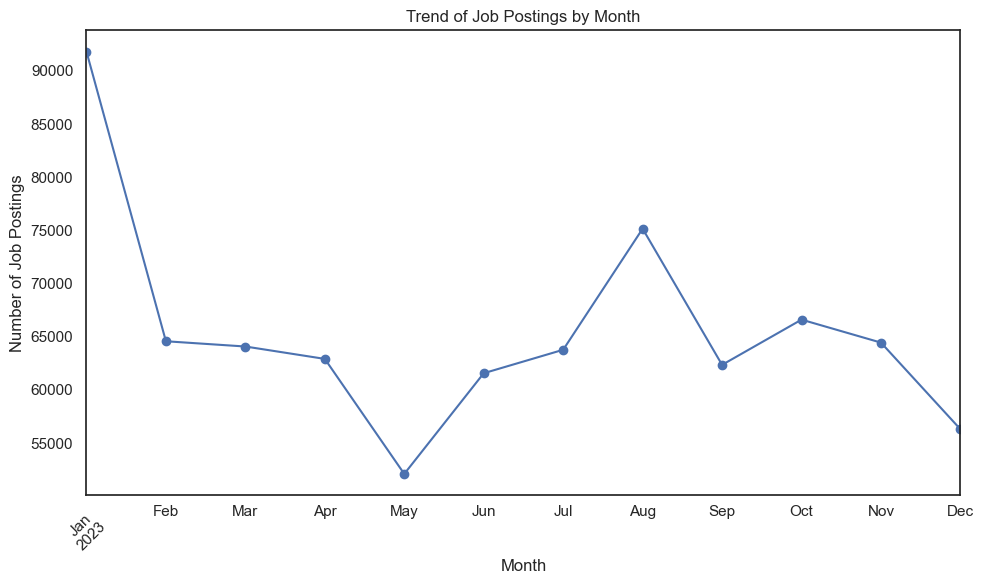

In [35]:
sns.set_theme(style='white')


# Assuming df['job_posted_date'] contains job posting job_posted_dates
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

# Extract the month and year from the job_posted_date
df['month_year'] = df['job_posted_date'].dt.to_period('M')

# Count job postings by month
monthly_postings = df['month_year'].value_counts().sort_index()

# Plotting the trend of job postings per month
plt.figure(figsize=(10, 6))
monthly_postings.plot(kind='line', marker='o')
plt.title('Trend of Job Postings by Month')
plt.xlabel('Month')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
